In [1]:
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle

import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import pad
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(str(Path(".").resolve().parent.parent))

from berp.datasets import BerpDataset, NestedBerpDataset

In [3]:
story_name = "old-man-and-the-sea"
subject = 1
run = 2

# aligned_words = "word.csv"
# aligned_phonemes = "phoneme.csv"
aligned_words = f"../../workflow/heilbron2022/data/aligned/distilgpt2/{story_name}/word.csv"
aligned_phonemes = f"../../workflow/heilbron2022/data/aligned/distilgpt2/{story_name}/phoneme.csv"

# stimulus = "old-man-and-the-sea/run2.pkl"
stimulus = f"../../workflow/heilbron2022/data/stimulus/distilgpt2/{story_name}/run{run}.pkl"

run_Xy = f"../../workflow/heilbron2022/data/run_Xy/{story_name}/sub{subject}/run{run}.h5"
# run_Xy = "/home/jgauthie/om2/others/heilbron2022/notebooks/exported/Xy/words_proba/sub1/run2.h5"

target_sample_rate = 128
output_path = f"{story_name}.sub{subject}.run{run}.pkl"

## Load and process natural language stimulus

In [4]:
with Path(stimulus).open("rb") as f:
    story_stim = pickle.load(f)
    
assert story_stim.name == f"{story_name}/run{run}"

In [5]:
# Variable onset features are simply a variable onset intercept,
# word features and word surprisals.
X_variable = torch.concat(
    [torch.ones_like(story_stim.word_surprisals).unsqueeze(1),
     story_stim.word_features,
     story_stim.word_surprisals.unsqueeze(1)],
    dim=1)
variable_feature_names = ["recognition_onset"] + story_stim.word_feature_names + ["word_surprisal"]

assert X_variable.shape[1] == len(variable_feature_names)

In [6]:
variable_feature_names

['recognition_onset', 'word_frequency', 'word_surprisal']

## Load aligned word/phoneme presentation data

In [7]:
word_aligned_df = pd.read_csv(aligned_words, index_col=[0, 1]).loc[run].reset_index()
phoneme_aligned_df = pd.read_csv(aligned_phonemes, index_col=[0, 1]).loc[run].reset_index()
word_aligned_df

,word_idx,word,onset,offset,token_idx
0,0,WHEN,1.17,1.31,688
1,1,THE,1.31,1.37,689
2,2,WIND,1.37,1.61,690
3,3,WAS,1.61,1.77,691
4,4,IN,1.77,1.87,692
...,...,...,...,...,...
567,541,AND,179.26,179.35,1364
568,542,YOUR,179.35,179.56,1365
569,543,EYES,179.56,179.77,1366
570,544,ARE,179.77,179.83,1367


### Check for words missing in stimulus

{16,
 46,
 68,
 116,
 141,
 170,
 199,
 227,
 278,
 301,
 326,
 349,
 370,
 399,
 451,
 503,
 526}

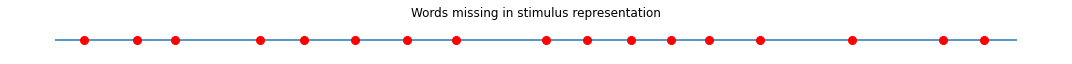

In [8]:
# Not all words in the presentation will be retained in the stimulus: words which
# ended up at the start of an input time series to the model were dropped, because
# the model didn't have those values as targets.
#
# By the above logic, the missing words will likely be distributed roughly evenly
# throughout the stimulus.
words_missing_in_stimulus = set(word_aligned_df.word_idx) - set(story_stim.word_ids.numpy())

plt.figure(figsize=(15, 1))
plt.hlines(0, 0, story_stim.word_ids.max())
plt.plot(list(words_missing_in_stimulus), np.zeros(len(words_missing_in_stimulus)), 'ro', ms=8, mfc='r')
plt.axis('off')
plt.title("Words missing in stimulus representation")
plt.tight_layout()

words_missing_in_stimulus

In [9]:
assert 0 == len(set(story_stim.word_ids.numpy()) - set(word_aligned_df.word_idx)), \
    "Stim words are present which are missing from the aligned data!"

## Load design matrix data

In [10]:
with h5py.File(run_Xy) as f:
    assert subject == f.attrs["subject"]
    assert run == f.attrs["run"]
    
    X = f["X"][()]
    y = f["y"][()].T
    
    sensor_names = f.attrs["ch_names"].tolist()
    ts_feature_names = f.attrs["feature_names"].tolist()
    sfreq = f.attrs["sfreq"]

In [11]:
assert X.shape[0] == y.shape[0]
assert X.shape[1] == len(ts_feature_names)
assert y.shape[1] == len(sensor_names)

### Add intercept feature to time series

In [12]:
X = np.hstack([np.ones((X.shape[0], 1)), X])
ts_feature_names = ['intercept'] + ts_feature_names

### Remove surprisal+frequency data

In [13]:
drop_ts_features = ["all_words_lexical_surprise", "all_words_unigram_surprise"]
keep_ts_feature_idxs = [i for i, name in enumerate(ts_feature_names) if name not in drop_ts_features]

X = X[:, keep_ts_feature_idxs]
ts_feature_names = [name for i, name in enumerate(ts_feature_names) if i in keep_ts_feature_idxs]
ts_feature_names

['intercept',
 'all_words_onset',
 'c_words_onset',
 'c_words_contextual_dissimilarity',
 'all_phons_pitch',
 'all_phons_env_var',
 'all_phons_sg1',
 'all_phons_sg2',
 'all_phons_sg3',
 'all_phons_sg4',
 'all_phons_sg5',
 'all_phons_sg6',
 'all_phons_sg7',
 'all_phons_sg8']

### SKIP: Align onset data

(There are many mismatches between the onset data given in the design matrix and the raw onset data from the Heilbron stimulus. This is due to some internal logic of the rERP design matrix prep in Heilbron that I don't understand. Instead of trying to understand and harmonize, I just decided to redo the onset computations instead. See next section.)

The design matrix is arranged such that the first word onset is $t=0$. Update the alignment dataframes to reflect this

In [14]:
# word_onset_idx = ts_feature_names.index("all_words_onset")
# X_onset_times = X[:, word_onset_idx].nonzero()[0] / sfreq
# X_onset_times[:10]

In [15]:
# shift = word_aligned_df.onset.min()
# word_aligned_df["onset"] -= shift
# word_aligned_df["offset"] -= shift
# phoneme_aligned_df["onset"] -= shift
# phoneme_aligned_df["offset"] -= shift
# phoneme_aligned_df["offset_word"] -= shift

# # TODO check consistency

# # TODO check: every word onset should have a phoneme with corresponding onset;
# # every word offset should have a phoneme with corresponding offset

In [16]:
# plt.figure(figsize=(15, 2))
# plt.hlines(0, 0, X_onset_times.max())
# plt.plot(X_onset_times, np.zeros(len(X_onset_times)), 'ro', ms=8, mfc='r')
# plt.plot(word_aligned_df.onset.values, np.ones(len(word_aligned_df)), 'go', ms=8)
# plt.axis('off')
# plt.tight_layout()

In [17]:
# # Find overlap
# array1 = X_onset_times
# array2 = word_aligned_df.onset.unique()
# import itertools
# from tqdm.auto import trange
# matches = []
# no_match = []
# for i0 in trange(array1.shape[0]):
#     for i1 in range(array2.shape[0]):
#         if np.isclose(array1[i0], array2[i1], atol=1e-1):
#             matches.append((i0, i1))
#             break
#     else:
#         no_match.append(i0)

In [18]:
# len(no_match)

In [19]:
# len(matches)

In [20]:
# no_match[:5]

In [21]:
# X_onset_times[40:60]

In [22]:
# X_onset_times[no_match[:5]]

In [23]:
# plt.figure(figsize=(15, 2))
# plt.hlines(0, 0, X_onset_times.max())
# mask = np.zeros(len(X_onset_times), dtype=bool)
# mask[no_match] = True
# plt.plot(X_onset_times[mask], np.zeros(mask.sum()), 'ro', ms=8, mfc='r', alpha=0.3)
# plt.plot(X_onset_times[~mask], np.zeros((~mask).sum()), 'ro', ms=8, mfc='g', alpha=0.3)
# # plt.plot(word_aligned_df.onset.values, np.ones(len(word_aligned_df)), 'go', ms=8)
# plt.axis('off')
# plt.tight_layout()

#### TODO: investigate evident misalignment here

Looks like there's a misalignment that starts with the onset of a new sentence "Santiago" and may trigger a massive misalignment for rest of run.

For now we'll put up with this incongruity in the pipeline.

In [24]:
# word_aligned_df.iloc[40:60]

In [25]:
# len(X_onset_times), len(word_aligned_df)

### Shift aligned word/phoneme data

Design matrix is shifted such that the time series begins exactly at the first word onset. Shift word / phoneme onsets accordingly.

In [26]:
shift = word_aligned_df.onset.min()
word_aligned_df["onset"] -= shift
word_aligned_df["offset"] -= shift
phoneme_aligned_df["onset"] -= shift
phoneme_aligned_df["offset"] -= shift
phoneme_aligned_df["offset_word"] -= shift

# TODO check consistency

# TODO check: every word onset should have a phoneme with corresponding onset;
# every word offset should have a phoneme with corresponding offset

## Load signal data

In [27]:
min_time, max_time = 0, len(X) / sfreq
max_time

163.7265625

In [28]:
# Check compatibility with alignment data.
assert min_time <= word_aligned_df.onset.min()
assert min_time <= phoneme_aligned_df.onset.min()

# NB looks like the last sentence-ish of each run is truncated from the signal
# data. TODO double check this with authors?
# assert max_time >= word_aligned_df.offset.max()
# assert max_time >= phoneme_aligned_df.offset.max()
chopped_words = word_aligned_df.offset >= max_time
chopped_phonemes = phoneme_aligned_df.offset >= max_time
print(f"{chopped_words.sum()}, {chopped_phonemes.sum()} chopped words/phonemes. Dropping.")

word_aligned_df = word_aligned_df.loc[~chopped_words]
phoneme_aligned_df = phoneme_aligned_df.loc[~chopped_phonemes]

45, 130 chopped words/phonemes. Dropping.


In [29]:
word_aligned_df.tail()

,word_idx,word,onset,offset,token_idx
522,498,TO,161.71,161.80,1305
523,499,COME,161.80,161.98,1306
524,500,OUT,161.98,162.14,1307
525,501,AFTER,162.14,162.37,1308
526,502,DOLPHIN,162.37,162.85,1309


In [30]:
# We may have residual phonemes without a corresponding word now. Remove those.
orphaned_phonemes = ~phoneme_aligned_df.word_idx.isin(word_aligned_df.word_idx)
if orphaned_phonemes.any():
    print(f"Also dropping {orphaned_phonemes.sum()} orphaned phonemes.")
    phoneme_aligned_df = phoneme_aligned_df.loc[~orphaned_phonemes]

In [31]:
# Check consistency.
assert set(word_aligned_df.word_idx) == set(phoneme_aligned_df.word_idx)

## Replace onset features

In [32]:
word_aligned_df["onset"] = (word_aligned_df["onset"] * target_sample_rate).round() / target_sample_rate
word_aligned_df["offset"] = (word_aligned_df["offset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["onset"] = (phoneme_aligned_df["onset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["offset"] = (phoneme_aligned_df["offset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["offset_word"] = (phoneme_aligned_df["offset_word"] * target_sample_rate).round() / target_sample_rate

/tmp/ipykernel_47749/3278703401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_aligned_df["onset"] = (word_aligned_df["onset"] * target_sample_rate).round() / target_sample_rate
/tmp/ipykernel_47749/3278703401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_aligned_df["offset"] = (word_aligned_df["offset"] * target_sample_rate).round() / target_sample_rate


In [33]:
word_onset_samples = (word_aligned_df["onset"] * target_sample_rate).astype(int)
phoneme_onset_samples = (phoneme_aligned_df["onset"] * target_sample_rate).astype(int)

word_onset_features = np.zeros((len(X), 1))
phoneme_onset_features = np.zeros((len(X), 1))
word_onset_features[word_onset_samples] = 1
phoneme_onset_features[phoneme_onset_samples] = 1

X = np.concatenate((X, word_onset_features, phoneme_onset_features), axis=1)
ts_feature_names += ["word_onset", "phoneme_onset"]
assert X.shape[1] == len(ts_feature_names)

In [34]:
# Remove Heilbron onset data.
remove_onset_features = ["all_words_onset", "c_words_onset", "all_phons_onset"]
for feat in remove_onset_features:
    try:
        feat_idx = ts_feature_names.index(feat)
    except ValueError:
        L.warning(f"No feature {feat}")
    else:
        X = np.delete(X, feat_idx, axis=1)
        ts_feature_names = ts_feature_names[:feat_idx] + ts_feature_names[feat_idx + 1:]
        
assert X.shape[1] == len(ts_feature_names)

No feature all_phons_onset


## Produce BerpDataset representations

In [35]:
# Now produce onset information from canonical aligned data.
# NB this will contain NaNs if there was misalignment above.
word_onsets = word_aligned_df.groupby("word_idx").onset.min().to_dict()
word_onsets = torch.tensor([word_onsets.get(word_id.item(), np.nan)
                            for word_id in story_stim.word_ids])

word_offsets = word_aligned_df.groupby("word_idx").offset.max().to_dict()
word_offsets = torch.tensor([word_offsets.get(word_id.item(), np.nan)
                             for word_id in story_stim.word_ids])

In [36]:
# Compute phoneme onsets relative to word onset.
phoneme_onsets = phoneme_aligned_df.groupby("word_idx") \
    .apply(lambda xs: list(xs.onset - xs.onset.min())).to_dict()
phoneme_onsets = [torch.tensor(phoneme_onsets.get(word_id.item(), [np.nan]))
                  for word_id in story_stim.word_ids]

In [37]:
max_num_phonemes = max(len(onsets) for onsets in phoneme_onsets)
# Sanity check: max_num_phonemes as computed from aligned data should
# match that produced earlier by the natural language stimulus processor
assert max_num_phonemes == story_stim.max_n_phonemes, \
    "%d %d" % (max_num_phonemes, story_stim.max_n_phonemes)

In [38]:
# Pad phoneme onset information
phoneme_onsets = torch.stack([
    pad(onsets, (0, max_num_phonemes - len(onsets)), value=0.)
    if len(onsets) < max_num_phonemes
    else onsets
    for onsets in phoneme_onsets
])

In [39]:
dataset = BerpDataset(
    name=f"{story_name}/sub{subject}/run{run}",
    stimulus_name=story_stim.name,
    sample_rate=sfreq,
    
    phonemes=story_stim.phonemes,
    
    word_onsets=word_onsets,
    word_offsets=word_offsets,
    phoneme_onsets=phoneme_onsets,
    
    X_ts=X,
    ts_feature_names=ts_feature_names,
    
    X_variable=X_variable,
    variable_feature_names=variable_feature_names,
    
    Y=y,
    sensor_names=sensor_names,
)

In [40]:
with Path(output_path).open("wb") as f:
    pickle.dump(dataset, f)